## Problem Statement: 
** For the current location and time, predict how long a passanger will be stuck in traffic in the city of Quito, Eor? **

### Loading required packages

In [632]:
import pandas as pd
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]
%matplotlib inline
color = sns.color_palette()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Load dataset for Quito city

In [633]:
data = pd.read_csv("uio_clean.csv", parse_dates=['pickup_datetime'])
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
0,1,Quito,2016-09-17 09:32:06,2016-09-17 10:05:51,-78.504,-0.233,-78.549,-0.361,N,2025,24228,346
1,2,Quito,2016-09-18 04:03:20,2016-09-18 04:26:30,-78.440,0.007,-78.491,-0.105,N,1390,16680,456
2,3,Quito,2016-09-16 06:29:36,2016-09-18 06:41:33,-78.470,-0.144,-78.470,-0.131,N,130317,1987,290
3,4,Quito,2016-09-18 05:57:47,2016-09-18 06:30:00,-78.558,-0.278,-78.430,-0.202,N,1933,25146,302
4,5,Quito,2016-09-18 07:58:42,2016-09-18 08:14:29,-78.522,-0.208,-78.505,-0.222,N,948,4625,314


### Split Train/Test

- Taking a small subset for testing before analyzing and preprocessing the Dataset so that we can replicate the original dataset and the distribution while final testing. Also, it'll help us in avoiding overfitting on validation set.

In [634]:
# split train and test (80-20)
np.random.seed(3)
n = data.shape[0]
inx = np.random.permutation(n)
n_sample = int(0.8*n)
train = data[data.index.isin(inx[:n_sample])]
test = data[~data.index.isin(inx[:n_sample])]
print(train.shape, test.shape)

((25892, 12), (6474, 12))


### Summarize the DataSet

In [635]:
train.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
count,25892.000,25892.000,25892.000,25892.000,25892.000,25892.000,25892.000,25892.000
mean,16141.528,-78.492,-0.189,-78.493,-0.191,38341.191,6653.554,22906781.438
std,9346.730,0.044,0.077,0.046,0.088,409606.982,18460.798,798654247.020
min,1.000,-80.682,-3.454,-80.682,-3.575,-388711.000,20.000,0.000
25%,8017.500,-78.506,-0.218,-78.506,-0.221,500.000,2155.750,106.000
50%,16143.500,-78.490,-0.182,-78.490,-0.185,894.000,4118.000,242.000
75%,24220.250,-78.476,-0.148,-78.477,-0.150,1701.000,7460.250,498.000
max,32364.000,-78.010,0.456,-77.710,0.819,24627195.000,1959571.000,95163057054.000


1. After looking at the summary, we can see the minimum value for wait_sec is 0 which can be possible, in case driver got the clear road throughout the trip but a value of 95163057054 (26434182.515 hours) clearly shows the driver forgot to switch off the meter. No way someone waited for so long in a trip.

2. Similarly, a distance of 1959571 (1959.571 KM) does not make sense. So clearly there are some outliers we need to deal with.

3. Trip duration also has some outliers but this information will not be available during trip start/booking, so we will use it only for EDA or removing faulty observations.

In [636]:
# checking the number of NAs in all variables
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dist_meters           0
wait_sec              0
dtype: int64

In [637]:
# Unique Value counts
for col in list(train.columns):
    print (str(col) + '----    ' + str(len(train[col].unique())) )

id----    25892
vendor_id----    4
pickup_datetime----    25503
dropoff_datetime----    25498
pickup_longitude----    25505
pickup_latitude----    25513
dropoff_longitude----    25511
dropoff_latitude----    25519
store_and_fwd_flag----    1
trip_duration----    6180
dist_meters----    11716
wait_sec----    2987


In [638]:
# Column data type and number of values in column 
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25892 entries, 0 to 32363
Data columns (total 12 columns):
id                    25892 non-null int64
vendor_id             25892 non-null object
pickup_datetime       25892 non-null datetime64[ns]
dropoff_datetime      25892 non-null object
pickup_longitude      25892 non-null float64
pickup_latitude       25892 non-null float64
dropoff_longitude     25892 non-null float64
dropoff_latitude      25892 non-null float64
store_and_fwd_flag    25892 non-null object
trip_duration         25892 non-null int64
dist_meters           25892 non-null int64
wait_sec              25892 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(4), object(3)
memory usage: 2.6+ MB


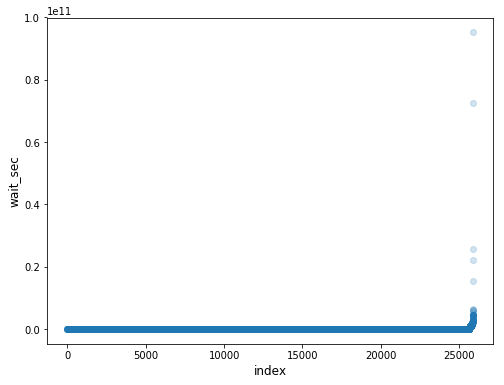

In [639]:
# let's look at the target variable
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train["wait_sec"].values), alpha=0.2)
plt.xlabel('index', fontsize=12)
plt.ylabel('wait_sec', fontsize=12)
plt.show()

In [640]:
train.shape

(25892, 12)

### Let's see the distribution of our target variable- wait_sec

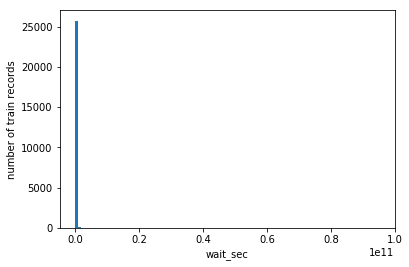

In [641]:
fig, ax = plt.subplots()
# ax.ticklabel_format(useOffset=False, style='plain')
ax.hist(train['wait_sec'], bins= 100)
plt.xlabel('wait_sec')
plt.ylabel('number of train records')
plt.show()

Visualizing wait_sec did not help much as some of the extremely large values are distorting everything, let's look at the log value and log value. Taking log makes sense as because in wait_sec some of the values will be really small and some will be extremely large, all needs to be bring somewhat together using log. 

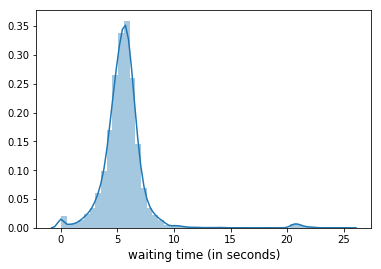

In [642]:
plt.figure(figsize=(6,4))
sns.distplot(np.log(train.wait_sec.values +1), bins=50, kde=True)
plt.xlabel('waiting time (in seconds)', fontsize=12)
plt.show()

     This looks much better than the previous one.
     It clearly shows some outliers, Let's look at the quantiles in data cleaning section and truncate them

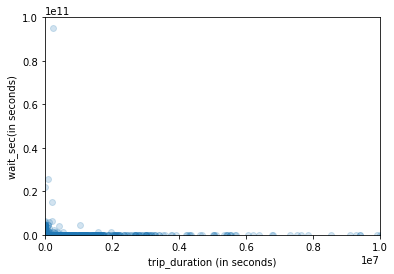

array([[ 1.        ,  0.21358968],
       [ 0.21358968,  1.        ]])

In [643]:
### Let's look at the wait sec and trip duration plot
y = train['wait_sec']
x = train['trip_duration']
plt.scatter(x, y, alpha=0.2)
plt.xlabel('trip_duration (in seconds)')
plt.ylabel('wait_sec(in seconds)')
plt.xlim(-10, 1*1e7)
plt.ylim(-10, 1*1e11)
plt.show()
np.corrcoef(x,y)

There seems a lot of outliers in trip duration as well as in wait sec, Let's do a clean up

### Data Cleaning

- wait_sec clean up

In [644]:
train["wait_sec"].quantile([.0, 0.01, 0.03, 0.05, 0.25, .5, 0.75,0.90, 0.92, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1])

0.000             0.000
0.010             0.000
0.030             9.000
0.050            18.000
0.250           106.000
0.500           242.000
0.750           498.000
0.900          1070.000
0.920          1311.720
0.940          1772.540
0.950          2198.900
0.960          2908.360
0.970          4319.270
0.980          7999.360
0.990        460644.910
1.000   95163057054.000
Name: wait_sec, dtype: float64

In [645]:
train[train["wait_sec"] > 1000 ].iloc[:,:18].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
11,12,Quito,2016-09-17 04:15:09,2016-09-18 12:28:12,-78.511,-0.240,-78.510,-0.238,N,72784,251,2418
35,36,Quito,2016-09-15 07:05:04,2016-09-19 07:33:14,-78.481,-0.122,-78.487,-0.119,N,304091,7366,1396
51,52,Quito,2016-09-19 10:21:23,2016-09-19 10:32:07,-78.488,-0.172,-78.487,-0.191,N,644,2386,761386356
67,68,Quito,2016-09-19 11:39:07,2016-09-19 12:19:30,-78.480,-0.189,-78.501,-0.212,N,2423,3714,1821
77,78,Quito,2016-09-19 12:43:55,2016-09-19 02:46:04,-78.432,-0.139,-78.417,-0.137,N,7330,59823,2513


1000 second (around 92 quantile) seems a pretty decent threshold as in daily city life on an average 15-20 min delay happens in a trip, there can be some instances where it is more than 20 min (in that case we, might require external data sources like weather data, Fastest Route information of Quito etc.)  Moreover, by looking at some of the observations manually, for 1 km there is more than 30 min wait time which clearly does not make sense, hence a lot of observations are faulty, probably driver forgot to stop the trip/meter, took a detour or stopped earlier.

In [646]:
train = train[train["wait_sec"] <= 1000]
print train.shape

(23095, 12)


- trip_duration clean up:- Although we will not use it directly in our model as in real life scenario, this will not be available during booking time, but we will use it for target encoding & to remove faulty observations

In [647]:
train["trip_duration"].quantile([.0, 0.001, 0.01, 0.05, 0.25, .5, 0.75, 0.90, 0.92, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999, 1])

0.000          3.000
0.001          8.094
0.010         21.000
0.050        100.000
0.250        469.000
0.500        810.000
0.750       1374.000
0.900       2638.000
0.920       3510.440
0.940       9226.880
0.950      25683.800
0.960      56212.120
0.970      86620.080
0.980     204618.360
0.990     513001.680
0.999    4592614.894
1.000   19355368.000
Name: trip_duration, dtype: float64

In [648]:
train = train[train["trip_duration"] >= 60]        #  any one will atleast take 1 minute ride, else would walk
train = train[train["trip_duration"] < 3600*2]     # 2 hours are enough to go from one end of the city to another in Quito

- Travelling on extreme ends in Quito would take maximum 2 hours.

<img src = "boundary_points_quito.jpg" alt="Boundary points" style="width: 300px; height = 300px" />

#### Latitude and Longitude cleaning

The Lat/Long coordinates of borders of Quito City are:

    quito_border_longitude = (-78.34, -78.62)
    quito_border_latitude = (-0.03, -0.37)

Comparing this to our `train.describe()` output we see that there are some coordinate points (pick ups/drop offs) that fall outside these borders. So let's limit our area of investigation to within the Quito City borders.

In [649]:
train = train[train['pickup_longitude'] <= -78.34]
train = train[train['pickup_longitude'] >= -78.62]
train = train[train['pickup_latitude'] <= -0.03]
train = train[train['pickup_latitude'] >= -0.37]
# train = train[train['dropoff_longitude'] <= -78.44]
train = train[train['dropoff_longitude'] <= -78.34]
train = train[train['dropoff_longitude'] >= -78.62]
train = train[train['dropoff_latitude'] <= -0.03]
train = train[train['dropoff_latitude'] >= -0.37]

- Actually, the boundary for Quito has to be extended a bit till the airport (inclusing the right colored line)
- I have figured these boundary latitude and longitudes manually using OSM api (https://nominatim.openstreetmap.org/search.php?q=quito&polygon_geojson=1&viewbox=)

<img src = "Quito.jpg", alt="Quito Boundary" style="width: 400px; height = 400px" />

In [650]:
train.shape

(20737, 12)

- Let's create variable speed, it is not a feature for our model since it needs trip duration which is also not available during booking. We are using it just as part of our exploration.

In [651]:
train["speed"] = train["dist_meters"]/train["trip_duration"]        # metre/second

In [652]:
train["speed"].quantile([.0, 0.01, 0.25, .5, 0.75, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999, 1])

0.000     0.003
0.010     0.178
0.250     3.861
0.500     5.271
0.750     6.847
0.950    10.091
0.960    10.552
0.970    11.234
0.980    12.233
0.990    13.869
0.999    34.955
1.000   339.857
Name: speed, dtype: float64

In [653]:
# train = train[train["speed"] <= 35]
# train = train[train["speed"] > 0]

Haversine distance:- Great circle distance between 2 points.

In [654]:
from math import radians, cos, sin, asin, sqrt
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

haversine(0.006788902,-78.44030559, -0.104836398, -78.49078607)

13.622392296891269

1. In the given dist_meters variable, the given distance is the distance which the driver has covered, it can be a few meters more or less than actual distance as most of the times driver go off the gps route or find some shortcut etc. But this is something we can not know prior to the trip ends and considering our business problem at hand, it makes sense to use the actual distance in both training as well as test set. Using the driver distance in train set and actual distance from test will make our train and test set come from a different distribution.

2. Also, we can add the expected time to reach from source to destination using google distance api. (There is a limit to the api, daily 2500). This will improve our model's accuracy.

In [655]:
# google distance api

# import urllib2
# import json
# def distance_using_maps(lat1, long1, lat2, long2):
#     url= r'http://maps.googleapis.com/maps/api/distancematrix/json?origins=' + str(lat1) +"," + str(long1)+ "&destinations="+ str(lat2)+","+str(long2)
#     response =  urllib2.urlopen(url)
#     data = json.load(response)   
#     return float(data["rows"][0]["elements"][0]["duration"]["value"])
# distance_using_maps(-0.153,-78.482, -0.161, -78.498)

In [656]:
# add a distance column using google maps
train["new_distance"] = train.apply(lambda x: haversine(x[u'pickup_latitude'], x[u'pickup_longitude'], x[u'dropoff_latitude'], x[u'dropoff_longitude']), axis=1)
test["new_distance"] = test.apply(lambda x: haversine(x[u'pickup_latitude'], x[u'pickup_longitude'], x[u'dropoff_latitude'], x[u'dropoff_longitude']), axis=1)

# # add a distance column using google maps
# train["new_duration"] = train.apply(lambda x: distance_using_maps(x[u'pickup_latitude'], x[u'pickup_longitude'], x[u'dropoff_latitude'], x[u'dropoff_longitude']), axis=1)
# test["new_duration"] = test.apply(lambda x: distance_using_maps(x[u'pickup_latitude'], x[u'pickup_longitude'], x[u'dropoff_latitude'], x[u'dropoff_longitude']), axis=1)

In [657]:
train = train[train["new_distance"] > 0 ]

In [658]:
train["new_distance"].quantile([.0, 0.01, 0.25, .5, 0.75, 0.90, 0.95, 0.97, 0.98, 0.999, 1])

0.000    0.000
0.010    0.014
0.250    1.254
0.500    2.430
0.750    4.236
0.900    7.035
0.950    9.239
0.970   11.038
0.980   12.515
0.999   24.462
1.000   30.268
Name: new_distance, dtype: float64

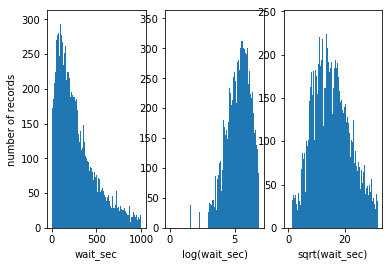

In [659]:
# It may be a good idea to transform the "y" variable
# Look for a transformation that give you a plot closer to a normal
train['log_wait_sec'] = np.log(train['wait_sec'].values + 1)
train['sqrt_wait_sec'] = np.sqrt(train['wait_sec'].values)

test['log_wait_sec'] = np.log(test['wait_sec'].values + 1)
test['sqrt_wait_sec'] = np.sqrt(test['wait_sec'].values)

fig, ax = plt.subplots(ncols=3, sharex=False, sharey=False)
ax[0].hist(train['wait_sec'].values, bins=200)
ax[1].hist(train['log_wait_sec'].values, bins=200)
ax[2].hist(train['sqrt_wait_sec'].values, bins=200)
ax[0].set_ylabel('number of records')
ax[0].set_xlabel('wait_sec')
ax[1].set_xlabel('log(wait_sec)')
ax[2].set_xlabel('sqrt(wait_sec)')
plt.show()

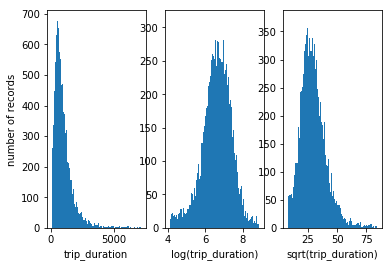

In [660]:
# It may be a good idea to transform the "y" variable
# Look for a transformation that give you a plot closer to a normal
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
train['sqrt_trip_duration'] = np.sqrt(train['trip_duration'].values)

test['log_trip_duration'] = np.log(test['trip_duration'].values + 1)
test['sqrt_trip_duration'] = np.sqrt(test['trip_duration'].values)

fig, ax = plt.subplots(ncols=3, sharex=False, sharey=False)
ax[0].hist(train['trip_duration'].values, bins=200)
ax[1].hist(train['log_trip_duration'].values, bins=200)
ax[2].hist(train['sqrt_trip_duration'].values, bins=200)
ax[0].set_ylabel('number of records')
ax[0].set_xlabel('trip_duration')
ax[1].set_xlabel('log(trip_duration)')
ax[2].set_xlabel('sqrt(trip_duration)')
plt.show()

### Adding Data time Features

In [661]:
# can add isHoliday also
def get_time_features(df):
#     df["yearmonth"] = df["pickup_datetime"].dt.year*100 + df["pickup_datetime"].dt.month
    df["pickup_month_of_year"] = df["pickup_datetime"].dt.month
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    df['pickup_weekofyear'] = df['pickup_datetime'].dt.weekofyear
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']
    df['pickup_minutes'] = df['pickup_datetime'].dt.minute
    return df

In [662]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date

train = get_time_features(train)
test = get_time_features(test)

- we have data from after morning 1 AM to before 12 PM

In [663]:
train.groupby('pickup_hour').size(),test.groupby('pickup_hour').size()

(pickup_hour
 1     1136
 2     1021
 3      963
 4     1093
 5     1523
 6     2299
 7     2688
 8     2929
 9     2287
 10    1898
 11    1557
 12    1337
 dtype: int64, pickup_hour
 1     369
 2     341
 3     303
 4     360
 5     510
 6     676
 7     816
 8     814
 9     721
 10    605
 11    489
 12    470
 dtype: int64)

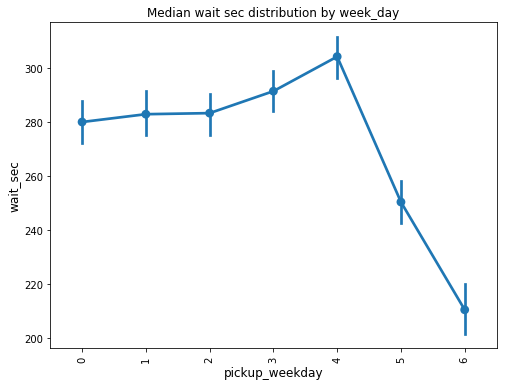

In [664]:
plt.figure(figsize=(8,6))
sns.pointplot(x='pickup_weekday', y='wait_sec', data=train)
plt.ylabel('wait_sec', fontsize=12)
plt.xlabel('pickup_weekday', fontsize=12)
plt.title('Median wait sec distribution by week_day')
plt.xticks(rotation='vertical')
plt.show()

There is a highest median waiting time on fridays and minimum on saturdays and sunday. Probably on fridays everybody leaves for party and some leave for their nearby city hometown.

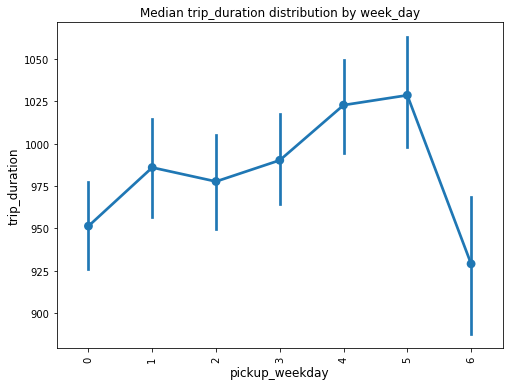

In [665]:
plt.figure(figsize=(8,6))
sns.pointplot(x='pickup_weekday', y='trip_duration', data=train)
plt.ylabel('trip_duration', fontsize=12)
plt.xlabel('pickup_weekday', fontsize=12)
plt.title('Median trip_duration distribution by week_day')
plt.xticks(rotation='vertical')
plt.show()

- On Fridays and saturdays, there are long trips taken by people in Quito, probably some can be tourists who are exploring the city on weekends and some might be running their pending work/errands on weekends

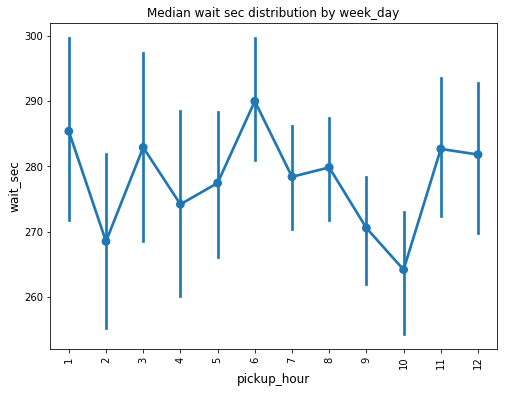

In [666]:
plt.figure(figsize=(8,6))
sns.pointplot(x='pickup_hour', y='wait_sec', data=train)
plt.ylabel('wait_sec', fontsize=12)
plt.xlabel('pickup_hour', fontsize=12)
plt.title('Median wait sec distribution by week_day')
plt.xticks(rotation='vertical')
plt.show()

- Waiting time in Quito is high between 5 to 8 AM, drops between 9 AM to 10 AM and then again rise from 11.

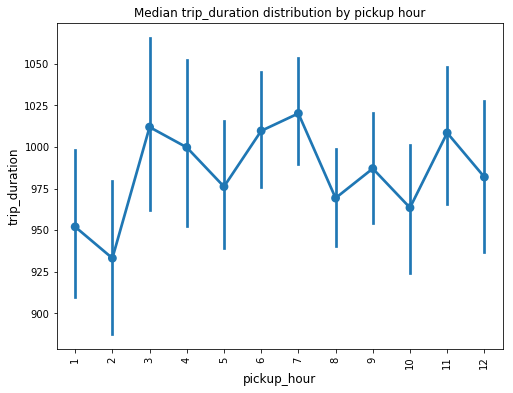

In [667]:
plt.figure(figsize=(8,6))
sns.pointplot(x='pickup_hour', y='trip_duration', data=train)
plt.ylabel('trip_duration', fontsize=12)
plt.xlabel('pickup_hour', fontsize=12)
plt.title('Median trip_duration distribution by pickup hour')
plt.xticks(rotation='vertical')
plt.show()

- There are long trips between 2-4 AM, probably people are going to airport or railway station. Also, long trips between 5-8 AM could be because of working hours.

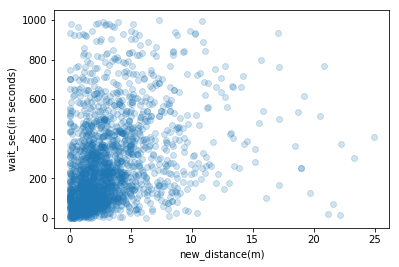

array([[ 1.        ,  0.29930747],
       [ 0.29930747,  1.        ]])

In [668]:
y = train['wait_sec'][:2000]
x = train['new_distance'][:2000]
plt.scatter(x, y, alpha=0.2)
plt.xlabel('new_distance(m)')
plt.ylabel('wait_sec(in seconds)')
plt.show()
np.corrcoef(x,y)

- Let's look at how good is our train test distribution

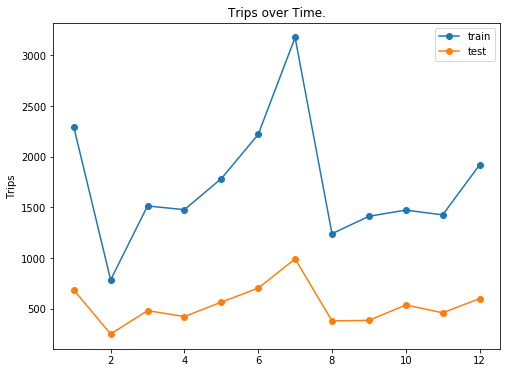

In [669]:
plt.subplots(1,1,figsize=(8,6))
plt.plot(train.groupby('pickup_month_of_year').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_month_of_year').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

Distribution of train and test looks similar when grouped by pickup hour.

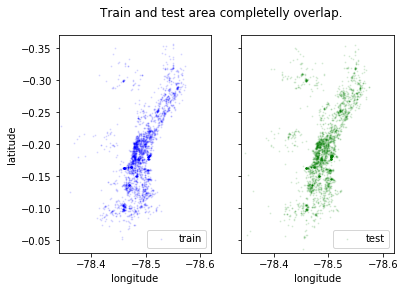

In [740]:
N = 3000
quito_border_longitude = (-78.34, -78.62)
quito_border_latitude = (-0.03, -0.37)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area completelly overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(quito_border_latitude)
plt.xlim(quito_border_longitude)
plt.show()

Let's see how significantly (or not significantly at all) the 4 vendors differ in their respective mean wait time durations:

Text(0,0.5,u'Wait Time in Seconds')

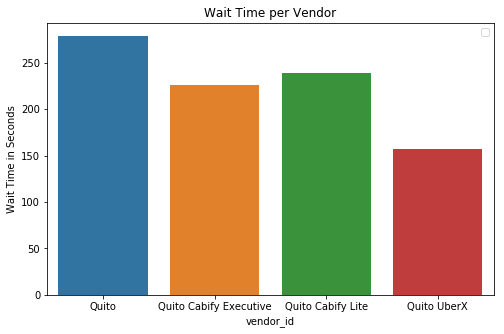

In [670]:
plot_vendor = train.groupby('vendor_id')['wait_sec'].mean()
plt.subplots(1,1,figsize=(8,5))
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Wait Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Wait Time in Seconds')

In [671]:
train["vendor_id"].value_counts()

Quito                     20469
Quito Cabify Lite           221
Quito Cabify Executive       40
Quito UberX                   1
Name: vendor_id, dtype: int64

- Majority of the data is of Quito Vendor.

### Neighbourhood analysis:- Clustering

- Let's look at the visualization of pickup and dropoff points on a map

<img src = "pickup_dropoff.jpg" alt="pickup_dropoff_points_viz" style="width: 400px; height = 400px" />

- Red points are the pickup points and blue are the drop-off points.
- Apparently, the center of Quito is where a lot of pickup and drop is happening, it could be the heart of the city
- There are some outlier, which are pointing pickup/drop from out of the city some drops towards airport (on the right upward side)

In [672]:
places = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [673]:
kmeans = MiniBatchKMeans(n_clusters=20, batch_size=10000).fit(places)

In [674]:
# Nc = range(1, 20)

# kmeans = [KMeans(n_clusters=i) for i in Nc]

# kmeans

# score = [kmeans[i].fit(places).score(places) for i in range(len(kmeans))]

# score

# plt.plot(Nc,score)

# plt.xlabel('Number of Clusters')

# plt.ylabel('Score')

# plt.title('Elbow Curve')

# plt.show()

In [675]:
# here the new features is the id of the cluster
train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test['pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

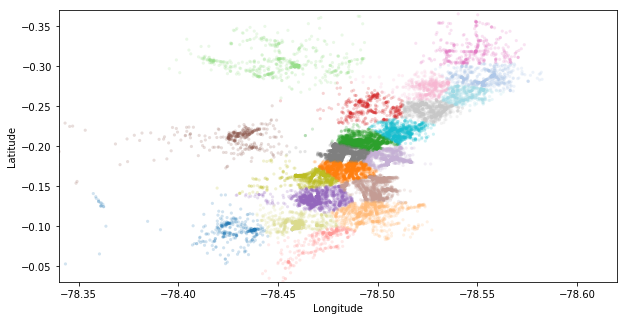

In [676]:
N = train.shape[0]
quito_border_longitude = (-78.34, -78.62)
quito_border_latitude = (-0.03, -0.37)
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(10,5))
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(quito_border_longitude)
ax.set_ylim(quito_border_latitude)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#There are some weird outliers here

- This projection of image map is inverted with respect to actual position on world map

In [677]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,sqrt_trip_duration,pickup_date,pickup_month_of_year,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_week_hour,pickup_minutes,pickup_cluster,dropoff_cluster
0,1,Quito,2016-09-17 09:32:06,2016-09-17 10:05:51,-78.504,-0.233,-78.549,-0.361,N,2025,...,45.000,2016-09-17,9,5,37,9,129,32,6,12
5,6,Quito,2016-08-27 04:19:02,2016-08-27 04:44:12,-78.509,-0.195,-78.519,-0.229,N,1510,...,38.859,2016-08-27,8,5,34,4,124,19,9,18
6,7,Quito,2016-09-18 10:08:57,2016-09-18 10:31:18,-78.482,-0.154,-78.518,-0.192,N,1341,...,36.620,2016-09-18,9,6,37,10,154,8,2,9
7,8,Quito,2016-09-18 11:06:58,2016-09-18 11:53:59,-78.530,-0.249,-78.361,-0.125,N,2821,...,53.113,2016-09-18,9,6,37,11,155,6,15,0
8,9,Quito,2016-09-18 11:54:04,2016-09-18 12:12:23,-78.361,-0.125,-78.393,-0.089,N,1100,...,33.166,2016-09-18,9,6,37,11,155,54,0,0


### Splitting training and validation

In [678]:
train["pickup_cluster"] = train["pickup_cluster"].astype('category')
train["dropoff_cluster"] = train["dropoff_cluster"].astype('category')
train["vendor_id"] = train["vendor_id"].astype('category')

from sklearn.preprocessing import LabelEncoder
train['vendor_id'] = train["vendor_id"].cat.codes

test["pickup_cluster"] = test["pickup_cluster"].astype('category')
test["dropoff_cluster"] = test["dropoff_cluster"].astype('category')
test["vendor_id"] = test["vendor_id"].astype('category')
test['vendor_id'] = test["vendor_id"].cat.codes

In [679]:
# split train and validation
train.reset_index(inplace=True)
np.random.seed(3)
n = train.shape[0]
inx = np.random.permutation(n)
n_sample = int(0.8*n)
print n_sample
train_set = train[train.index.isin(inx[:n_sample])]
val_set = train[~train.index.isin(inx[:n_sample])]
print(train_set.shape, val_set.shape)
train_set = train_set.drop(['index'], axis=1)
val_set = val_set.drop(['index'], axis=1)

16584
((16584, 28), (4147, 28))


### Target Encoding

Here is an example of what is called 'Target Encoding'. The idea here is given a categorical variable, create a new variable that is the mean each categorical value variable in the training data.

Note that I divided the train and validation sets before doing this. Since the computation of these involve the target variable, we do it in the training and transfer it to the test/ validation sets.

In [680]:
train_set.dtypes

id                               int64
vendor_id                         int8
pickup_datetime         datetime64[ns]
dropoff_datetime                object
pickup_longitude               float64
pickup_latitude                float64
dropoff_longitude              float64
dropoff_latitude               float64
store_and_fwd_flag              object
trip_duration                    int64
dist_meters                      int64
wait_sec                         int64
speed                          float64
new_distance                   float64
log_wait_sec                   float64
sqrt_wait_sec                  float64
log_trip_duration              float64
sqrt_trip_duration             float64
pickup_date                     object
pickup_month_of_year             int64
pickup_weekday                   int64
pickup_weekofyear                int64
pickup_hour                      int64
pickup_week_hour                 int64
pickup_minutes                   int64
pickup_cluster           

In [681]:
for col in ['vendor_id','pickup_weekday', 'pickup_weekofyear', 'pickup_hour',
       'pickup_week_hour', 'pickup_month_of_year', 'pickup_minutes', 'pickup_cluster', 'dropoff_cluster']:
    gby = train_set.groupby(col).mean()[["speed", 'log_trip_duration','log_wait_sec']]
    gby.columns = ['%s_gby_%s' % (c, col) for c in gby.columns]
    train_set = pd.merge(train_set, gby, how='left', left_on=col, right_index=True)
    val_set = pd.merge(val_set, gby, how='left', left_on=col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=col, right_index=True)

## Modelling

In [742]:
train_set.columns

Index([u'id', u'vendor_id', u'pickup_datetime', u'dropoff_datetime',
       u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude',
       u'dropoff_latitude', u'store_and_fwd_flag', u'trip_duration',
       u'dist_meters', u'wait_sec', u'speed', u'new_distance', u'log_wait_sec',
       u'sqrt_wait_sec', u'log_trip_duration', u'sqrt_trip_duration',
       u'pickup_date', u'pickup_month_of_year', u'pickup_weekday',
       u'pickup_weekofyear', u'pickup_hour', u'pickup_week_hour',
       u'pickup_minutes', u'pickup_cluster', u'dropoff_cluster',
       u'speed_gby_vendor_id', u'log_trip_duration_gby_vendor_id',
       u'log_wait_sec_gby_vendor_id', u'speed_gby_pickup_weekday',
       u'log_trip_duration_gby_pickup_weekday',
       u'log_wait_sec_gby_pickup_weekday', u'speed_gby_pickup_weekofyear',
       u'log_trip_duration_gby_pickup_weekofyear',
       u'log_wait_sec_gby_pickup_weekofyear', u'speed_gby_pickup_hour',
       u'log_trip_duration_gby_pickup_hour', u'log_wait_sec_gby_

In [743]:
train_set.shape

(16584, 54)

- **Data used for building model**

In [744]:
ind = [1, 4, 5, 6, 7, 13] + list(range(19, 54))
features = train_set.columns[ind]
features

Index([u'vendor_id', u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'new_distance',
       u'pickup_month_of_year', u'pickup_weekday', u'pickup_weekofyear',
       u'pickup_hour', u'pickup_week_hour', u'pickup_minutes',
       u'pickup_cluster', u'dropoff_cluster', u'speed_gby_vendor_id',
       u'log_trip_duration_gby_vendor_id', u'log_wait_sec_gby_vendor_id',
       u'speed_gby_pickup_weekday', u'log_trip_duration_gby_pickup_weekday',
       u'log_wait_sec_gby_pickup_weekday', u'speed_gby_pickup_weekofyear',
       u'log_trip_duration_gby_pickup_weekofyear',
       u'log_wait_sec_gby_pickup_weekofyear', u'speed_gby_pickup_hour',
       u'log_trip_duration_gby_pickup_hour', u'log_wait_sec_gby_pickup_hour',
       u'speed_gby_pickup_week_hour',
       u'log_trip_duration_gby_pickup_week_hour',
       u'log_wait_sec_gby_pickup_week_hour', u'speed_gby_pickup_month_of_year',
       u'log_trip_duration_gby_pickup_month_of_year',
       u'log_wai

In [745]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def print_score(true, pred):
    print ('MAE = '+ str(mean_absolute_error(true, pred)))
    print ('RMSE = '+ str(np.sqrt(((pred - true) ** 2).mean())))

### Linear Regression

In [746]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept = True, normalize=True, copy_X=True, n_jobs=-1)
lr.fit(train_set[features], train_set["wait_sec"].values)
pred_val = lr.predict(val_set[features])

In [747]:
val_y = val_set['wait_sec'].values
pred = pred_val
res = pd.DataFrame({'pred': pred, 'y': val_y})
print_score(res.y,res.pred)
res.head(10)

MAE = 163.114209067
RMSE = 212.765046315


,pred,y
0,320.125,510
1,610.250,302
2,211.875,390
3,170.750,43
4,278.500,126
5,121.250,963
6,213.625,341
7,307.375,125
8,285.375,895
9,271.625,356


#### Lasso

In [748]:
from sklearn import linear_model

lr_lasso = linear_model.Lasso(alpha=0.8)
lr_lasso.fit(train_set[features], train_set["wait_sec"].values)

Lasso(alpha=0.8, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [749]:
# Number of coefficients turned to 0 by lasso
sum(lr_lasso.coef_ == 0)

24

In [750]:
pred_val = lr_lasso.predict(val_set[features])
val_y = val_set['wait_sec'].values
pred = pred_val
res = pd.DataFrame({'pred': pred, 'y': val_y})
print_score(res.y,res.pred)

MAE = 163.284726013
RMSE = 212.330496705


#### Ridge

In [751]:
from sklearn import linear_model

lr_ridge = linear_model.Ridge(alpha=0.9)
lr_ridge.fit(train_set[features], train_set["wait_sec"].values)

Ridge(alpha=0.9, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [752]:
# Number of coefficients turned close to 0 by ridge
lr_ridge.coef_

array([ -1.74013133e+01,   2.50991760e+02,  -9.75174415e+00,
         5.50307702e+01,  -2.27026719e+02,   2.14375129e+01,
        -9.21326137e-01,   5.21230535e-02,   4.65593956e-01,
        -1.22952614e+00,   2.14271720e-02,  -1.58415977e-02,
         1.68126433e-02,   1.71301063e-01,  -1.57645276e+01,
         4.47337593e+01,   3.07415142e+01,  -4.47181155e+00,
        -4.91058309e+01,   6.72806181e+00,  -1.64317432e+01,
         3.03637746e+01,   1.00109768e+02,  -4.15250824e+01,
         9.51438371e+01,  -5.50860667e+01,  -1.34351515e+01,
         2.64090471e+01,   1.28718961e+02,  -5.24447121e+00,
         6.49087487e+01,   1.00235849e+01,  -4.38801729e+00,
         2.87069925e+01,   1.07337614e+02,   7.13439683e-01,
        -6.75918464e+01,   1.41044475e+02,   5.02023705e+00,
        -4.64885916e+01,   1.46972218e+02])

In [753]:
pred_val = lr_ridge.predict(val_set[features])
val_y = val_set['wait_sec'].values
pred = pred_val
res = pd.DataFrame({'pred': pred, 'y': val_y})
print_score(res.y,res.pred)

MAE = 163.425187285
RMSE = 212.67485091


### Random Forest

In [754]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs=-1,max_features='sqrt',oob_score=True, 
                                     n_estimators=100,min_samples_split=80,min_samples_leaf=40)
rf.fit(train_set[features], train_set.wait_sec.values)

pred_val = rf.predict(val_set[features])

In [755]:
val_y = val_set['wait_sec'].values
pred = pred_val
res_rf = pd.DataFrame({'pred': pred, 'y': val_y})
print_score(res_rf.y,res_rf.pred)
res_rf.head()

MAE = 158.732083491
RMSE = 206.145660405


,pred,y
0,275.318,510
1,278.835,302
2,199.804,390
3,198.527,43
4,242.208,126


In [756]:
import matplotlib.pyplot as plt
% matplotlib inline

feature_imp = pd.DataFrame({'cols':train_set[features].columns, 'imp':rf.feature_importances_}).sort_values('imp', ascending=False)
feature_imp

print "Features sorted by their score:"
print feature_imp

Features sorted by their score:
                                          cols   imp
5                                 new_distance 0.327
2                              pickup_latitude 0.050
37             log_wait_sec_gby_pickup_cluster 0.049
3                            dropoff_longitude 0.043
1                             pickup_longitude 0.043
4                             dropoff_latitude 0.042
35                    speed_gby_pickup_cluster 0.040
38                   speed_gby_dropoff_cluster 0.039
40            log_wait_sec_gby_dropoff_cluster 0.038
28           log_wait_sec_gby_pickup_week_hour 0.028
26                  speed_gby_pickup_week_hour 0.023
10                            pickup_week_hour 0.021
36        log_trip_duration_gby_pickup_cluster 0.018
22          log_wait_sec_gby_pickup_weekofyear 0.016
27      log_trip_duration_gby_pickup_week_hour 0.015
34             log_wait_sec_gby_pickup_minutes 0.013
33        log_trip_duration_gby_pickup_minutes 0.013
21     log_tri

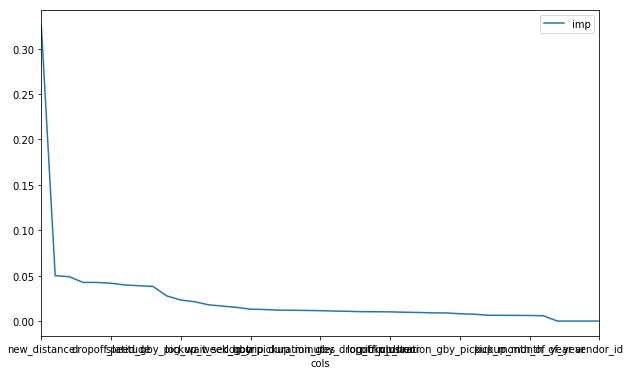

In [757]:
feature_imp.plot('cols', 'imp', figsize=(10,6), legend=True)

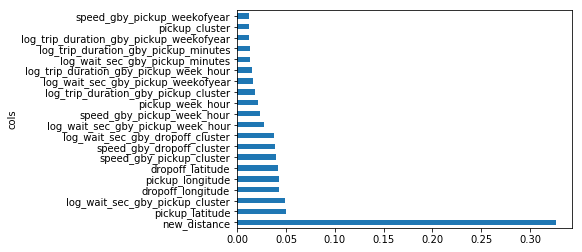

In [758]:
feature_imp[0:20].plot('cols', 'imp', 'barh', legend=False)

In [759]:
feature_imp[feature_imp.imp>0.01].cols

5                                new_distance
2                             pickup_latitude
37            log_wait_sec_gby_pickup_cluster
3                           dropoff_longitude
1                            pickup_longitude
4                            dropoff_latitude
35                   speed_gby_pickup_cluster
38                  speed_gby_dropoff_cluster
40           log_wait_sec_gby_dropoff_cluster
28          log_wait_sec_gby_pickup_week_hour
26                 speed_gby_pickup_week_hour
10                           pickup_week_hour
36       log_trip_duration_gby_pickup_cluster
22         log_wait_sec_gby_pickup_weekofyear
27     log_trip_duration_gby_pickup_week_hour
34            log_wait_sec_gby_pickup_minutes
33       log_trip_duration_gby_pickup_minutes
21    log_trip_duration_gby_pickup_weekofyear
12                             pickup_cluster
20                speed_gby_pickup_weekofyear
39      log_trip_duration_gby_dropoff_cluster
7                              pic

- Feature importance:- We can select features till where the elbow bends and build our model which will be less complex than this.

In [760]:
selected_features = feature_imp[feature_imp.imp>0.01].cols

#### Hyperparameter Tuning

In [761]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs=-1,max_features='sqrt',oob_score=True, 
                                     n_estimators=200,min_samples_split=80,min_samples_leaf=40)
rf.fit(train_set[selected_features], train_set.wait_sec.values)

pred_val = rf.predict(val_set[selected_features])

In [762]:
val_y = val_set['wait_sec'].values
pred = pred_val
res_rf = pd.DataFrame({'pred': pred, 'y': val_y})
print_score(res_rf.y,res_rf.pred)
res_rf.head()

MAE = 157.281840875
RMSE = 205.192715415


,pred,y
0,294.153,510
1,295.817,302
2,197.081,390
3,198.896,43
4,255.498,126


In [763]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100],
    'max_features': [0.1, 0.3, 0.5],
    'min_samples_leaf': [50, 100],
    'min_samples_split': [100, 200],
    'n_estimators': [100, 200, 300]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = False)

In [764]:
# Fit the grid search to the data
grid_search.fit(train_set[selected_features], train_set.wait_sec.values)
grid_search.best_params_
best_grid = grid_search.best_estimator_

print(best_grid)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features=0.5, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=50, min_samples_split=100,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)


In [765]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 0.5,
 'min_samples_leaf': 50,
 'min_samples_split': 100,
 'n_estimators': 300}

         hyper_parameter_results:- 
         {'bootstrap': True,
         'max_depth': 100,
         'max_features': 0.5,
         'min_samples_leaf': 50,
         'min_samples_split': 100,
         'n_estimators': 300}

- fitting after hyperparameter tuning and choosing best features

In [767]:
best_grid.fit(train_set[selected_features], train_set.wait_sec.values)

pred_val = best_grid.predict(val_set[selected_features])
val_y = val_set['wait_sec'].values
pred = pred_val
res_rf = pd.DataFrame({'pred': pred, 'y': val_y})
print_score(res_rf.y,res_rf.pred)
res_rf.head()

MAE = 156.304566297
RMSE = 204.694006584


,pred,y
0,298.682,510
1,326.162,302
2,213.777,390
3,212.887,43
4,249.940,126


- Performance improve slightly

## Funneling the important features into other ML models

### XGBoost

In [703]:

xgb_pars = {'min_child_weight': 40, 'eta': 0.1, 'colsample_bytree': 0.5, 'n_estimators': 1000,'max_depth': 5,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [704]:
# initially training on a subset of the data
# train_set = train_set[:5000]
print train_set.shape

train_y = train_set['wait_sec'].values
val_y = val_set['wait_sec'].values

dtrain = xgb.DMatrix(train_set[selected_features].values, label=train_y)
dvalid = xgb.DMatrix(val_set[selected_features].values, label=val_y)
dtest = xgb.DMatrix(test[selected_features].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

(16584, 54)


In [705]:
# train xgboost model
import datetime as dt
t0 = dt.datetime.now()
gbm = xgb.train(xgb_pars, dtrain, 2000, watchlist, early_stopping_rounds=50, verbose_eval=False)
t1 = dt.datetime.now()
print('Time fitting xgb: %i seconds' % (t1 - t0).seconds)

Time fitting xgb: 4 seconds


In [706]:
predictions = gbm.predict(dvalid)

In [707]:
val_y = val_set['wait_sec'].values
pred = predictions
res_xg = pd.DataFrame({'pred': pred, 'y': val_y})
print_score(res_xg.y,res_xg.pred)
res_xg.head()

MAE = 153.860679016
RMSE = 202.766723704


,pred,y
0,267.417,510
1,255.340,302
2,39.917,390
3,162.303,43
4,192.966,126


- saving xgboost model

In [728]:
import joblib

filename = "quito_model.pkl"
joblib.dump(gbm, filename) 

['quito_model.pkl']

### Neural Network

In [709]:
from keras.optimizers import SGD, RMSprop, adam
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=26))
model.add(Dense(16, activation='relu') )
# model.add(Dropout(0.2))
# model.add(Dense(8, activation='relu') )
# model.add(Dropout(0.2))
model.add(Dense(4, activation='relu') )
model.add(Dense(1))
opt = adam(lr=0.01)
# 
model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['accuracy'])

In [710]:
model.fit(train_set[selected_features].as_matrix(), train_set.wait_sec.values, nb_epoch=50, batch_size=32, verbose=0)

In [711]:
score = model.evaluate(val_set[selected_features].as_matrix(), val_set.wait_sec.values, batch_size=128, verbose=2)
print score[1]

0.000964552697225


In [712]:
predictions = model.predict(val_set[selected_features].as_matrix())

val_y = val_set['wait_sec'].values
pred = predictions.flatten()
res_nn = pd.DataFrame({'pred': pred, 'y': val_y})
print_score(res_nn.y,res_nn.pred)
res_nn.head()

MAE = 161.016061202
RMSE = 210.591052486


,pred,y
0,280.550,510
1,284.572,302
2,223.528,390
3,230.782,43
4,282.799,126


### Ensemble: Averaging

In [713]:
res_ensemble = pd.DataFrame()
res_ensemble["pred"] = (res_xg.pred + res_rf.pred + res_nn.pred)/3
res_ensemble["y"] = res_xg.y
res_ensemble.head()

,pred,y
0,279.120,510
1,278.382,302
2,154.309,390
3,197.566,43
4,240.477,126


In [714]:
print_score(res_ensemble.y,res_ensemble.pred)

MAE = 155.890687076
RMSE = 204.13060921


### Evaluating on unseen data : Test set

- Keeping in mind to run this model in production, Xgboost gave us the best results. We will use this for predicting on unseen data.
- For Evaluating our model unseen data, we will use the threshold from training set and use it to truncate extreme values(outliers) on unseen data.
- During deployment, this should be a business decision, whether to cap the outliers or predict as it is and flag them separately.

In [715]:
test = test[test["wait_sec"] <= 1000]
test = test[test["trip_duration"] >= 60]
test = test[test["trip_duration"] <= 3600*2]

test = test[test['pickup_longitude'] <= -78.34]
test = test[test['pickup_longitude'] >= -78.62]
test = test[test['pickup_latitude'] <= -0.03]
test = test[test['pickup_latitude'] >= -0.37]
test = test[test['dropoff_longitude'] <= -78.34]
test = test[test['dropoff_longitude'] >= -78.62]
test = test[test['dropoff_latitude'] <= -0.03]
test = test[test['dropoff_latitude'] >= -0.37]
print test.shape

(5195, 53)


In [716]:
test[selected_features].columns

Index([u'new_distance', u'pickup_latitude',
       u'log_wait_sec_gby_dropoff_cluster', u'speed_gby_pickup_cluster',
       u'dropoff_longitude', u'pickup_longitude', u'dropoff_latitude',
       u'log_wait_sec_gby_pickup_cluster', u'speed_gby_dropoff_cluster',
       u'speed_gby_pickup_week_hour', u'log_wait_sec_gby_pickup_week_hour',
       u'log_trip_duration_gby_pickup_cluster', u'pickup_week_hour',
       u'log_wait_sec_gby_pickup_weekofyear',
       u'log_wait_sec_gby_pickup_minutes',
       u'log_trip_duration_gby_pickup_week_hour',
       u'log_trip_duration_gby_dropoff_cluster',
       u'log_trip_duration_gby_pickup_weekofyear',
       u'log_trip_duration_gby_pickup_minutes', u'speed_gby_pickup_weekday',
       u'pickup_cluster', u'speed_gby_pickup_weekofyear', u'dropoff_cluster',
       u'pickup_weekday', u'speed_gby_pickup_minutes', u'pickup_hour'],
      dtype='object')

In [730]:
#load saved model
gbm_model = joblib.load(filename)

dtest = xgb.DMatrix(test[selected_features].values)

pred = gbm_model.predict(dtest)
test_y = test['wait_sec'].values
res_test = pd.DataFrame({'pred': pred, 'y': test_y})
print_score(res_test.y,res_test.pred)

# Adding predictions in test dataframe
test_df = test[selected_features]
test_df["pred_wait_sec"] = pred
test_df.head()

MAE = 150.110748051
RMSE = 198.44322


,new_distance,pickup_latitude,log_wait_sec_gby_dropoff_cluster,speed_gby_pickup_cluster,dropoff_longitude,pickup_longitude,dropoff_latitude,log_wait_sec_gby_pickup_cluster,speed_gby_dropoff_cluster,speed_gby_pickup_week_hour,...,log_trip_duration_gby_pickup_weekofyear,log_trip_duration_gby_pickup_minutes,speed_gby_pickup_weekday,pickup_cluster,speed_gby_pickup_weekofyear,dropoff_cluster,pickup_weekday,speed_gby_pickup_minutes,pickup_hour,pred_wait_sec
3,16.556,-0.278,4.585,5.643,-78.430,-78.558,-0.202,5.120,7.454,6.188,...,6.651,6.590,6.790,1,5.628,10,6,5.449,5,278.500
4,2.470,-0.208,5.159,5.243,-78.505,-78.522,-0.222,5.136,5.819,6.800,...,6.651,6.645,6.790,18,5.628,18,6,5.448,7,140.133
12,2.526,-0.159,5.475,4.922,-78.487,-78.465,-0.167,5.453,4.787,6.657,...,6.651,6.632,6.790,16,5.628,2,6,5.398,1,225.620
16,2.007,-0.153,5.270,5.666,-78.498,-78.482,-0.161,5.401,5.717,7.482,...,6.651,6.621,6.790,11,5.628,11,6,6.181,4,210.741
18,1.108,-0.263,5.118,5.189,-78.541,-78.549,-0.270,5.016,5.126,6.491,...,6.651,6.648,6.790,19,5.628,19,6,6.382,6,84.994


### Conclusion:-

- Clearly, model's performance is consistent on test and val set and is not overfitting on neither train,val nor test set.
- MAE = 150.110748051
- RMSE = 198.44322

Valid prediction mean: 277.913
Test prediction mean: 278.616


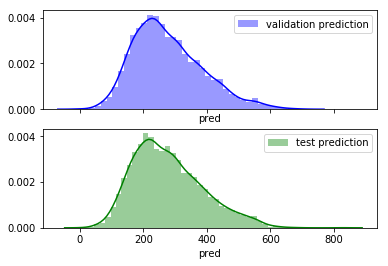

In [741]:
print('Valid prediction mean: %.3f' % res_xg.pred.mean())
print('Test prediction mean: %.3f' % res_test.pred.mean())

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(res_xg.pred, ax=ax[0], color='blue', label='validation prediction')
sns.distplot(res_test.pred, ax=ax[1], color='green', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

### Avearge waiting time from cluster to cluster on test data

- We have already predicted cluster on test data by running clustering on training data.
- We have also predicted waiting time using our predictive model.
- Now, let's leverage this information and find waiting time from cluster to cluster

In [718]:
pd.pivot_table(test_df,values=['pred_wait_sec'], index=['pickup_cluster'],columns=['dropoff_cluster'],aggfunc=[np.mean],fill_value=np.nan)

mean                                                  \
                pred_wait_sec                                                   
dropoff_cluster            0       1       2       3       4       5       6    
pickup_cluster                                                                  
0                     176.842     nan     nan 297.645     nan     nan 356.868   
1                     289.187 225.428     nan 332.199 498.532     nan 256.408   
2                     399.172 479.544 229.818 391.291 386.931     nan 359.323   
3                     361.380 293.013 403.802 161.664 449.284     nan 403.068   
4                     353.795 437.101 375.293 427.130 209.002 386.487 324.981   
5                     331.202 288.488 221.156     nan 431.739 208.841 198.278   
6                     360.036 310.951 349.168 260.590 305.099 261.145 198.034   
7                     242.876 352.434 419.635 221.766 594.489     nan     nan   
8                     325.285     nan 389.886 247.039 533.697     nan     nan   
9                     278.920 476.402 326.581 294.161 264.418 366.423 265.284   
10                    226.226 423.863     nan     nan     nan     nan 264.720   
11                    374.072 344.401 316.274 250.108 403.390     nan 288.987   
12                        nan 215.292 385.288 285.170     nan     nan 286.560   
13                        nan 283.911 337.276 393.444 448.447 426.496 233.750   
14                    310.461 436.925 327.750 419.086 282.209 331.784 320.262   
15                        nan 363.644 485.005 460.955 371.070     nan 244.646   
16                    387.640 444.699 332.782 452.033 477.702 416.004 169.384   
17                    206.618     nan 416.499 205.243 518.059     nan 312.511   
18                        nan 403.069 358.320 293.746 231.331 378.538 273.757   
19                    232.170 231.070 443.463 382.292 508.114 394.497 327.149   

                                                                         \
                                                                          
dropoff_cluster      7       8       9       10      11      12      13   
pickup_cluster                                                            
0               189.108 266.991 402.850 252.181 399.974     nan     nan   
1                   nan     nan 396.881 278.500 388.916 238.804 212.879   
2               445.522 356.042 274.943 346.023 301.599 494.660 440.844   
3               249.759 245.248 354.474 231.362 236.882 394.849 362.740   
4               542.071 462.011 237.167 364.102 394.084 478.477 435.137   
5                   nan     nan     nan 182.015     nan     nan 264.610   
6                   nan     nan 310.250 255.963 352.981 314.139 300.668   
7               190.351 284.236 515.622     nan 319.938     nan     nan   
8               328.787 207.846 458.913 447.031 287.518 490.352 442.033   
9               397.550 470.028 191.635 341.812 243.347 408.177     nan   
10              236.635     nan     nan 156.564     nan     nan     nan   
11              382.667 304.461 299.211     nan 230.938 691.188     nan   
12                  nan 288.198 359.375     nan 335.854 164.763 177.108   
13                  nan     nan     nan 279.693 296.762 363.072 237.451   
14              438.836 381.099 301.923 327.995 409.761     nan 394.543   
15              315.407     nan 313.668 285.674 426.324 394.494 251.464   
16              477.633 289.178 366.094 274.961 383.557     nan     nan   
17              167.954 228.875 466.653 179.120 346.036     nan     nan   
18              348.153 413.668 247.283     nan 312.997 519.730 357.530   
19                  nan 363.110 268.780     nan 544.301 322.838 202.317   

                                                                 
                                                                 
dropoff_cluster      14      15      16      17      18      19  
pickup_cluster                                                   
0              

### Deploying Model in Production -  AWS

1: A simple way to deploy model using AWS tools
- Once, the model is trained, we can use below steps to deploy our model:-
- **Save the model** in pickel or h5 format and upload the model artifacts on amazon S3.
- We need to serve our model using a web api. Using **Flask/Djano**, we can wrap our Machine Learning model and serve it as **Web APIs** easily.
- Next, we need to run any **AWS instance for running our web api** or we can create serverless Machine Learning microservice using **AWS Lambda**.
- We will **cache our model**, so that we don't have to fetch the model from S3 everytime we make predictions, leading to significantly faster prediction
- Next, we can call the API endpoints by sending the required data and **start making predictions** .We can also **save them simultaneously in database (SQL/NoSQL)**

2: We can also leveraging AWS SageMaker for the above mentioned tasks.
 
3: Considering the problem at hand, we can also run the model in an online learning fashion to adapt to changing traffic and city conditions.
- The idea is to update the weights of the model for each new pair of observation, in our case, probably when the ride is completed. Once, parameters or weights are updated, we can discard the observation.

#### Demo deployment using Flask

- I have deployed a web service using flask which is making predictions for the test data based on our final model.
- There is a folder named flask_apps. 
- Inside this, there is a data folder which contains the test data.
- model folder contains the final xgboost model, server.py contains the code for running the app, loading the model and generating predictions.
- prediction.py contains the logic for reading test data and generating the request to call api.

How to run:
- cd flask_apps/
- gunicorn --bind 0.0.0.0:8000 server:app
- run prediction.py
- Make predictions 